# TP 1, exercice 3: Classification simple d'images

Cet exercice est à réaliser avec l'environnement Jupyter d'Anaconda https://www.anaconda.com/

**Objectif:** Analyse en composantes principales, Classification par régression logistique  

In [ ]:
# Initialisations
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
#Pour calculer la moyenne de la liste
import statistics

## Données

On va utiliser des images en niveau de gris de visages, 

> Grayscale faces 8 bit `[0-255]`, a few images of several different people.
> 400 total images, 64x64 size.
> From the Olivetti database at ATT.

Fichier à télécharger: [olivettifaces.mat](http://www-l2ti.univ-paris13.fr/~viennet/ens/AFDV/data/olivettifaces.mat) (4,1Mo).

Le format est un peu spécial, il s'agit d'une matrice matlab. On va le lire comme suit:

In [ ]:
D = scipy.io.loadmat('./olivettifaces.mat') # modifier chemin si nécessaire
# La matrice est transposée (lignes/colonnes):
X = D['faces'].transpose()
print(X.shape)

(400, 4096)


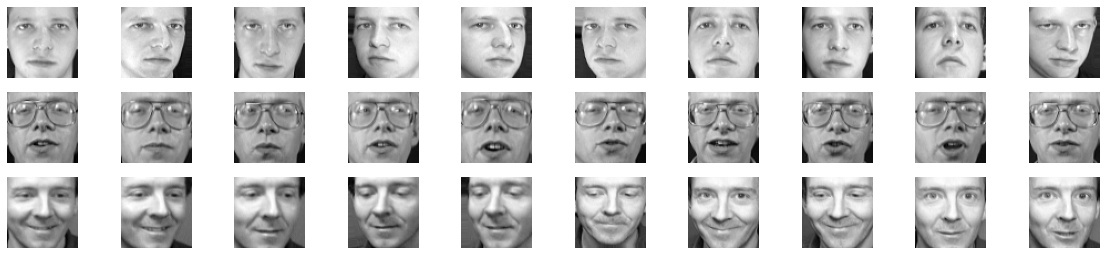

In [ ]:
# Affichage de quelques exemples:
plt.figure(figsize=(20,6))
N = 30 # nombre d'exemples à afficher
MaxNbPerLine = 10 

nrows = N // MaxNbPerLine + 1 
ncols = min(N, MaxNbPerLine)
index = 1 # indice dans la figure
for image in X[:N]:
    plt.subplot(nrows, ncols, index)
    plt.axis('off')    
    plt.imshow(image.reshape((64,64)).transpose(), cmap=plt.cm.gray)
    index += 1


On voit qu'on a dix images de chaque personne, dans l'ordre. Chaque image est de taille 64x64 = 4096 pixels.


## Image moyenne
Convertir les images en float, calculer et afficher l'image moyenne.

[96.8325 98.34   99.8825 ... 73.2575 74.8    75.13  ]


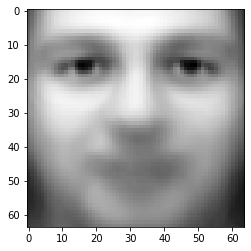

In [ ]:
#Convertir les images en float
images_float = X.astype(np.float64)

#print(images_float)

#X_mean = np.mean(images_float)
X_mean = sum(images_float)/len(X)

print(X_mean)

plt.figure()
plt.imshow(X_mean.reshape((64,64)).transpose(), cmap=plt.cm.gray)

## Analyse en composantes principales
Calculer une ACP pour projeter les images en deux dimensions et afficher les images dans le plan.

(400, 2)


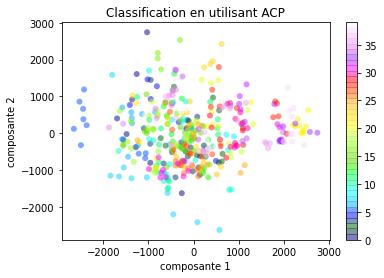

In [ ]:
# Modèle PCA: passe de 8x8=64 à 2 dimensions
pca = PCA(2) 
projected = pca.fit_transform(X)
print(projected.shape)
#Comme on a 10 images par personne 
classes = (np.arange(len(X))/10).astype(int)

plt.scatter(projected[:, 0], projected[:, 1],
            c=classes, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('gist_ncar',40))
plt.xlabel('composante 1')
plt.ylabel('composante 2')
plt.colorbar()
plt.rcParams['axes.facecolor'] = 'gray'
plt.title('Classification en utilisant ACP')

plt.show()

## Classification

Estimer un modèle de classification par régression logistique. Le modèle sera estimé (appris) sur 7 visages par personne, et testé sur les 3 images restantes.

On pourra s'inspirer de l'[exemple de la documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html)

Quelle est la personne sur laquelle le modèle commet le plus d'erreurs ?

In [ ]:
#Modèle d'apprentisage : 7 visages / 10
#Modèle de test : 3 visages / 10
index_apprentissage = []
index_test = []
for v in range(40):
    for i in range(7):
        index_apprentissage.append(v*10+i)
    for i in range(7,10):
        index_test.append(v*10+i)
        
X_apprentissage = X[index_apprentissage]
X_test = X[index_test]

Y = np.arange(0,400,0.1).astype(int)
Y_apprentissage = Y[index_apprentissage]
Y_test = Y[index_test]

print('On a', len(X_apprentissage), "exemples en apprentissage et", len(X_test),"exemples en test")

On a 280 exemples en apprentissage et 120 exemples en test


In [ ]:
#Modèle de régression logistique
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_apprentissage, Y_apprentissage)
logreg.predict(X_apprentissage[0:10])

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [ ]:
#Erreurs sur la data d'apprentissage
Y_apprentissage_pred = logreg.predict(X_apprentissage)
nb_erreur_apprentissage = sum(Y_apprentissage_pred != Y_apprentissage)
print("Nombre d'erreurs en apprentissage:", nb_erreur_apprentissage)

#Erruers sur la data de test
Y_test_pred = logreg.predict(X_test)
nb_erreur_test = sum(Y_test_pred != Y_test)

print("Nombre d'erreurs en test:", nb_erreur_test)

Nombre d'erreurs en apprentissage: 0
Nombre d'erreurs en test: 21


In [ ]:
nberreurs = []
for v in range(40):
    n=0
    for i in range(3):
        if Y_test_pred[v*3:(v+1)*3][i] != v:
            n += 1
        nberreurs.append(n)

In [ ]:
print("la personne sur laquelle le modèle commet le plus d'erreurs est", np.argmax(nberreurs))

la personne sur laquelle le modèle commet le plus d'erreurs est 14


### Erreur en fonction du nombre des composantes

In [ ]:
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

#dict_err = {}
#Listes des dimensions
dimensions = []

liste_erreurs = []
#for i in range (40,200):
for i in range (40,100):
    pca = PCA(i) 
    projected = pca.fit_transform(X)
    proj_apprentissage = projected[index_apprentissage]
    proj_test = projected[index_test]

    #Modèle de régression logistique
    logreg.fit(proj_apprentissage, Y_apprentissage)
    logreg.predict(proj_apprentissage[0:10])
    
    #Erreurs sur la data de test
    Y_test_pred = logreg.predict(proj_test)
    nb_erreur_test = sum(Y_test_pred != Y_test)
    liste_erreurs.append(nb_erreur_test)
    dimensions.append(i)


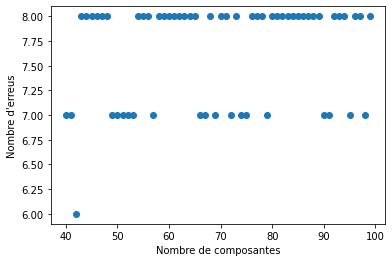

In [ ]:
plt.scatter(dimensions,liste_erreurs)
plt.xlabel('Nombre de composantes')
plt.ylabel("Nombre d'erreus")
plt.rcParams['axes.facecolor'] = 'white'